# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

2023-07-25 08:26:59.343182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#samples of length 1284
gamma1 = np.loadtxt("gamma1.dat.txt", dtype=float)
gamma2 = np.loadtxt("gamma2.dat.txt", dtype=float)
gamma3 = np.loadtxt("gamma3.dat.txt", dtype=float)
logp1_cgs = np.loadtxt("logp1.dat.txt", dtype=float)

logp1_si = logp1_cgs - 1

#input data

input1 = np.loadtxt("4m1.dat.txt", dtype=float)
input2 = np.loadtxt("4m2.dat.txt", dtype=float)
input3 = np.loadtxt("4l1.dat.txt", dtype=float)
input4 = np.loadtxt("4l2.dat.txt", dtype=float)

# Functions

In [3]:

def format_output(data):
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    gamma3 = data.pop('gamma3')
    gamma3 = np.array(gamma3)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    return gamma1, gamma2, gamma3, logp1_si


# MLA

In [4]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 8 ] * 1284)
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(1284, 8)


In [5]:
#reformat data files into this new array
for i in range(0,len(input1)-1):
    combined_array[i][0] = input1[i]
    combined_array[i][1] = input2[i]
    combined_array[i][2] = input3[i]
    combined_array[i][3] = input4[i]
    combined_array[i][4] = gamma1[i]
    combined_array[i][5] = gamma2[i]
    combined_array[i][6] = gamma3[i]
    combined_array[i][7] = logp1_si[i]
    

In [6]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2', 'gamma1', 'gamma2', 'gamma3', 'logp1_si']
print(data)

            m1        m2           l1            l2    gamma1    gamma2  \
0     2.210373  1.219939    16.090308    710.374860  3.625071  4.414359   
1     3.229345  1.710582    13.835052   6844.219115  2.294278  2.971584   
2     2.191554  2.146354    11.096783     14.043726  2.314338  3.939892   
3     2.378743  1.028031    22.961893   3784.226432  3.534009  3.946176   
4     2.310550  1.990112   141.695054    402.497979  2.940170  2.658312   
...        ...       ...          ...           ...       ...       ...   
1279  1.696450  1.088038  2488.844538  24393.040906  2.974858  2.079322   
1280  1.857231  1.274984    57.402591    602.225613  2.798993  3.975011   
1281  1.206364  1.156889  2117.913665   2792.962463  2.252906  3.597783   
1282  2.652053  1.498475    88.953600   3988.137893  2.748003  1.669605   
1283  0.000000  0.000000     0.000000      0.000000  0.000000  0.000000   

        gamma3   logp1_si  
0     1.258215  33.284946  
1     3.206806  34.177032  
2     2.993757 

In [7]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('gamma3')
train_stats.pop('logp1_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

            m1        m2          l1           l2    gamma1    gamma2  \
1232  2.550355  2.147015   16.126523   116.666889  3.703443  1.981819   
90    2.031032  1.987211   29.765541    36.606468  3.058350  3.209438   
1172  2.275282  1.513752   40.023754   786.004344  3.313330  2.392119   
1051  2.821597  1.469441   99.747837  4900.314837  3.156179  1.396918   
504   2.811115  2.492260   38.311783   115.544879  2.840712  2.262953   
...        ...       ...         ...          ...       ...       ...   
855   2.054641  1.970798   19.875715    28.685683  2.483875  3.984448   
109   1.324851  1.085560  546.019593  1511.076327  4.497279  4.471266   
115   2.408369  1.945360   40.139813   181.885074  4.153281  2.669805   
1239  2.343563  1.840193   34.677221   201.490077  2.685633  4.429208   
62    1.504211  1.480721  362.886765   400.750268  4.027866  2.685848   

        gamma3   logp1_si  
1232  2.262826  33.955844  
90    2.916776  33.491932  
1172  1.462290  33.829382  
1051  3.687

In [8]:
norm_train_X = train
norm_test_X = test

In [9]:
# build the model using the functional syntax

# output will be fed directly from the previous dense layer

input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='tanh')(input_layer)
second_dense = Dense(units='128', activation='tanh')(first_dense)

gamma1_output = Dense(units='1', name='gamma1_output')(second_dense)
third_dense = Dense(units='64', activation='tanh')(second_dense)

gamma2_output = Dense(units='1', name='gamma2_output')(third_dense)
fourth_dense = Dense(units='32',activation='tanh')(third_dense)

gamma3_output = Dense(units='1', name='gamma3_output')(fourth_dense)
fifth_dense = Dense(units='16',activation='tanh')(fourth_dense)

logp1_si_output = Dense(units='1', name='logp1_si_output')(fifth_dense)

model = Model(inputs=input_layer, outputs=[gamma1_output, gamma2_output, gamma3_output, logp1_si_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

2023-07-25 08:27:02.924707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


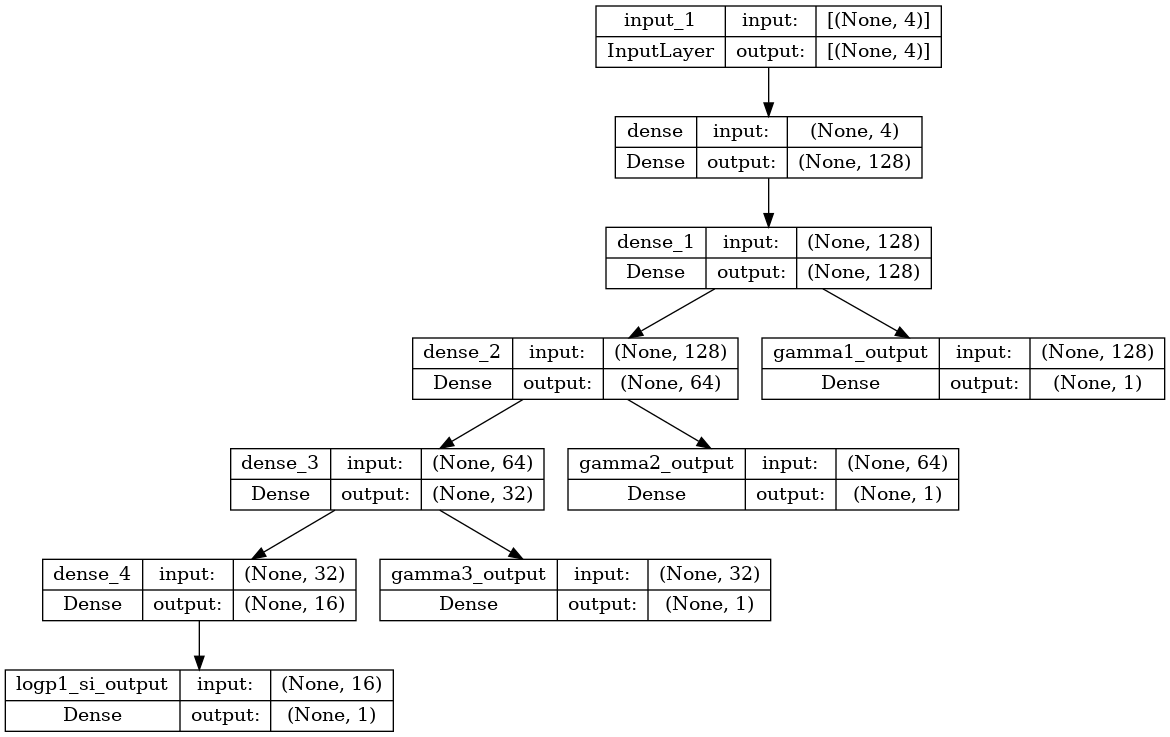

In [10]:
plot_model(model, to_file='4peice_combinedmll.png', show_shapes=True, show_layer_names=True)

In [15]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma1_output': 'mse', 'gamma2_output': 'mse', 'gamma3_output': 'mse', 'logp1_si_output': 'mse'},
              metrics={
                       'gamma1_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma2_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma3_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError()
                      })


endmetric = "mean_squared_error"

In [19]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=100,mode='auto')])



Epoch 1/200
83/83 [==============================] - 0s 4ms/step - loss: 442.3755 - gamma1_output_loss: 0.4585 - gamma2_output_loss: 0.7145 - gamma3_output_loss: 0.8108 - logp1_si_output_loss: 440.3917 - gamma1_output_mean_squared_error: 0.4585 - gamma2_output_mean_squared_error: 0.7145 - gamma3_output_mean_squared_error: 0.8108 - logp1_si_output_mean_squared_error: 440.3917 - val_loss: 440.4667 - val_gamma1_output_loss: 0.4918 - val_gamma2_output_loss: 0.7961 - val_gamma3_output_loss: 0.8916 - val_logp1_si_output_loss: 438.2874 - val_gamma1_output_mean_squared_error: 0.4918 - val_gamma2_output_mean_squared_error: 0.7961 - val_gamma3_output_mean_squared_error: 0.8916 - val_logp1_si_output_mean_squared_error: 438.2874
Epoch 2/200
83/83 [==============================] - 0s 4ms/step - loss: 436.4832 - gamma1_output_loss: 0.4558 - gamma2_output_loss: 0.7197 - gamma3_output_loss: 0.8125 - logp1_si_output_loss: 434.4951 - gamma1_output_mean_squared_error: 0.4558 - gamma2_output_mean_squared

83/83 [==============================] - 0s 5ms/step - loss: 379.7399 - gamma1_output_loss: 0.4613 - gamma2_output_loss: 0.7145 - gamma3_output_loss: 0.8114 - logp1_si_output_loss: 377.7527 - gamma1_output_mean_squared_error: 0.4613 - gamma2_output_mean_squared_error: 0.7145 - gamma3_output_mean_squared_error: 0.8114 - logp1_si_output_mean_squared_error: 377.7527 - val_loss: 377.9395 - val_gamma1_output_loss: 0.4878 - val_gamma2_output_loss: 0.7924 - val_gamma3_output_loss: 0.8930 - val_logp1_si_output_loss: 375.7663 - val_gamma1_output_mean_squared_error: 0.4878 - val_gamma2_output_mean_squared_error: 0.7924 - val_gamma3_output_mean_squared_error: 0.8930 - val_logp1_si_output_mean_squared_error: 375.7663
Epoch 13/200
83/83 [==============================] - 0s 3ms/step - loss: 374.2724 - gamma1_output_loss: 0.4584 - gamma2_output_loss: 0.7111 - gamma3_output_loss: 0.8108 - logp1_si_output_loss: 372.2919 - gamma1_output_mean_squared_error: 0.4584 - gamma2_output_mean_squared_error: 0.7

83/83 [==============================] - 0s 4ms/step - loss: 321.8819 - gamma1_output_loss: 0.4608 - gamma2_output_loss: 0.6906 - gamma3_output_loss: 0.8102 - logp1_si_output_loss: 319.9202 - gamma1_output_mean_squared_error: 0.4608 - gamma2_output_mean_squared_error: 0.6906 - gamma3_output_mean_squared_error: 0.8102 - logp1_si_output_mean_squared_error: 319.9202 - val_loss: 320.3359 - val_gamma1_output_loss: 0.5414 - val_gamma2_output_loss: 0.8431 - val_gamma3_output_loss: 0.8910 - val_logp1_si_output_loss: 318.0604 - val_gamma1_output_mean_squared_error: 0.5414 - val_gamma2_output_mean_squared_error: 0.8431 - val_gamma3_output_mean_squared_error: 0.8910 - val_logp1_si_output_mean_squared_error: 318.0604
Epoch 24/200
83/83 [==============================] - 0s 4ms/step - loss: 316.8700 - gamma1_output_loss: 0.4580 - gamma2_output_loss: 0.7019 - gamma3_output_loss: 0.8090 - logp1_si_output_loss: 314.9011 - gamma1_output_mean_squared_error: 0.4580 - gamma2_output_mean_squared_error: 0.7

83/83 [==============================] - 0s 3ms/step - loss: 268.8637 - gamma1_output_loss: 0.4536 - gamma2_output_loss: 0.7064 - gamma3_output_loss: 0.8084 - logp1_si_output_loss: 266.8952 - gamma1_output_mean_squared_error: 0.4536 - gamma2_output_mean_squared_error: 0.7064 - gamma3_output_mean_squared_error: 0.8084 - logp1_si_output_mean_squared_error: 266.8952 - val_loss: 267.3597 - val_gamma1_output_loss: 0.4966 - val_gamma2_output_loss: 0.8059 - val_gamma3_output_loss: 0.8917 - val_logp1_si_output_loss: 265.1655 - val_gamma1_output_mean_squared_error: 0.4966 - val_gamma2_output_mean_squared_error: 0.8059 - val_gamma3_output_mean_squared_error: 0.8917 - val_logp1_si_output_mean_squared_error: 265.1655
Epoch 35/200
83/83 [==============================] - 0s 5ms/step - loss: 264.2585 - gamma1_output_loss: 0.4555 - gamma2_output_loss: 0.6819 - gamma3_output_loss: 0.8097 - logp1_si_output_loss: 262.3114 - gamma1_output_mean_squared_error: 0.4555 - gamma2_output_mean_squared_error: 0.6

83/83 [==============================] - 0s 4ms/step - loss: 220.6197 - gamma1_output_loss: 0.4523 - gamma2_output_loss: 0.6822 - gamma3_output_loss: 0.8076 - logp1_si_output_loss: 218.6776 - gamma1_output_mean_squared_error: 0.4523 - gamma2_output_mean_squared_error: 0.6822 - gamma3_output_mean_squared_error: 0.8076 - logp1_si_output_mean_squared_error: 218.6776 - val_loss: 219.2221 - val_gamma1_output_loss: 0.4722 - val_gamma2_output_loss: 0.7736 - val_gamma3_output_loss: 0.8927 - val_logp1_si_output_loss: 217.0836 - val_gamma1_output_mean_squared_error: 0.4722 - val_gamma2_output_mean_squared_error: 0.7736 - val_gamma3_output_mean_squared_error: 0.8927 - val_logp1_si_output_mean_squared_error: 217.0836
Epoch 46/200
83/83 [==============================] - 0s 4ms/step - loss: 216.4886 - gamma1_output_loss: 0.4587 - gamma2_output_loss: 0.6875 - gamma3_output_loss: 0.8067 - logp1_si_output_loss: 214.5357 - gamma1_output_mean_squared_error: 0.4587 - gamma2_output_mean_squared_error: 0.6

83/83 [==============================] - 0s 3ms/step - loss: 177.2067 - gamma1_output_loss: 0.4476 - gamma2_output_loss: 0.6806 - gamma3_output_loss: 0.8061 - logp1_si_output_loss: 175.2724 - gamma1_output_mean_squared_error: 0.4476 - gamma2_output_mean_squared_error: 0.6806 - gamma3_output_mean_squared_error: 0.8061 - logp1_si_output_mean_squared_error: 175.2724 - val_loss: 176.4982 - val_gamma1_output_loss: 0.5972 - val_gamma2_output_loss: 1.1797 - val_gamma3_output_loss: 0.9031 - val_logp1_si_output_loss: 173.8182 - val_gamma1_output_mean_squared_error: 0.5972 - val_gamma2_output_mean_squared_error: 1.1797 - val_gamma3_output_mean_squared_error: 0.9031 - val_logp1_si_output_mean_squared_error: 173.8182
Epoch 57/200
83/83 [==============================] - 0s 3ms/step - loss: 173.5116 - gamma1_output_loss: 0.4551 - gamma2_output_loss: 0.6934 - gamma3_output_loss: 0.8058 - logp1_si_output_loss: 171.5572 - gamma1_output_mean_squared_error: 0.4551 - gamma2_output_mean_squared_error: 0.6

83/83 [==============================] - 0s 4ms/step - loss: 138.5972 - gamma1_output_loss: 0.4538 - gamma2_output_loss: 0.6731 - gamma3_output_loss: 0.8069 - logp1_si_output_loss: 136.6635 - gamma1_output_mean_squared_error: 0.4538 - gamma2_output_mean_squared_error: 0.6731 - gamma3_output_mean_squared_error: 0.8069 - logp1_si_output_mean_squared_error: 136.6635 - val_loss: 137.5013 - val_gamma1_output_loss: 0.4906 - val_gamma2_output_loss: 0.7580 - val_gamma3_output_loss: 0.8940 - val_logp1_si_output_loss: 135.3587 - val_gamma1_output_mean_squared_error: 0.4906 - val_gamma2_output_mean_squared_error: 0.7580 - val_gamma3_output_mean_squared_error: 0.8940 - val_logp1_si_output_mean_squared_error: 135.3587
Epoch 68/200
83/83 [==============================] - 0s 4ms/step - loss: 135.3261 - gamma1_output_loss: 0.4556 - gamma2_output_loss: 0.6681 - gamma3_output_loss: 0.8054 - logp1_si_output_loss: 133.3970 - gamma1_output_mean_squared_error: 0.4556 - gamma2_output_mean_squared_error: 0.6

83/83 [==============================] - 0s 4ms/step - loss: 104.7866 - gamma1_output_loss: 0.4511 - gamma2_output_loss: 0.6653 - gamma3_output_loss: 0.8043 - logp1_si_output_loss: 102.8659 - gamma1_output_mean_squared_error: 0.4511 - gamma2_output_mean_squared_error: 0.6653 - gamma3_output_mean_squared_error: 0.8043 - logp1_si_output_mean_squared_error: 102.8659 - val_loss: 103.8728 - val_gamma1_output_loss: 0.5232 - val_gamma2_output_loss: 0.7485 - val_gamma3_output_loss: 0.8889 - val_logp1_si_output_loss: 101.7122 - val_gamma1_output_mean_squared_error: 0.5232 - val_gamma2_output_mean_squared_error: 0.7485 - val_gamma3_output_mean_squared_error: 0.8889 - val_logp1_si_output_mean_squared_error: 101.7122
Epoch 79/200
83/83 [==============================] - 0s 4ms/step - loss: 101.9576 - gamma1_output_loss: 0.4533 - gamma2_output_loss: 0.6738 - gamma3_output_loss: 0.8036 - logp1_si_output_loss: 100.0269 - gamma1_output_mean_squared_error: 0.4533 - gamma2_output_mean_squared_error: 0.6

83/83 [==============================] - 0s 5ms/step - loss: 75.7800 - gamma1_output_loss: 0.4535 - gamma2_output_loss: 0.6555 - gamma3_output_loss: 0.8047 - logp1_si_output_loss: 73.8662 - gamma1_output_mean_squared_error: 0.4535 - gamma2_output_mean_squared_error: 0.6555 - gamma3_output_mean_squared_error: 0.8047 - logp1_si_output_mean_squared_error: 73.8662 - val_loss: 75.0734 - val_gamma1_output_loss: 0.5171 - val_gamma2_output_loss: 0.7807 - val_gamma3_output_loss: 0.8980 - val_logp1_si_output_loss: 72.8775 - val_gamma1_output_mean_squared_error: 0.5171 - val_gamma2_output_mean_squared_error: 0.7807 - val_gamma3_output_mean_squared_error: 0.8980 - val_logp1_si_output_mean_squared_error: 72.8775
Epoch 90/200
83/83 [==============================] - 0s 4ms/step - loss: 73.4177 - gamma1_output_loss: 0.4527 - gamma2_output_loss: 0.6785 - gamma3_output_loss: 0.8047 - logp1_si_output_loss: 71.4817 - gamma1_output_mean_squared_error: 0.4527 - gamma2_output_mean_squared_error: 0.6785 - ga

83/83 [==============================] - 0s 4ms/step - loss: 51.5965 - gamma1_output_loss: 0.4498 - gamma2_output_loss: 0.6597 - gamma3_output_loss: 0.8034 - logp1_si_output_loss: 49.6836 - gamma1_output_mean_squared_error: 0.4498 - gamma2_output_mean_squared_error: 0.6597 - gamma3_output_mean_squared_error: 0.8034 - logp1_si_output_mean_squared_error: 49.6836 - val_loss: 50.9388 - val_gamma1_output_loss: 0.4721 - val_gamma2_output_loss: 0.7329 - val_gamma3_output_loss: 0.8825 - val_logp1_si_output_loss: 48.8515 - val_gamma1_output_mean_squared_error: 0.4721 - val_gamma2_output_mean_squared_error: 0.7329 - val_gamma3_output_mean_squared_error: 0.8825 - val_logp1_si_output_mean_squared_error: 48.8515
Epoch 101/200
83/83 [==============================] - 0s 4ms/step - loss: 49.6417 - gamma1_output_loss: 0.4571 - gamma2_output_loss: 0.6692 - gamma3_output_loss: 0.8014 - logp1_si_output_loss: 47.7140 - gamma1_output_mean_squared_error: 0.4571 - gamma2_output_mean_squared_error: 0.6692 - g

83/83 [==============================] - 0s 3ms/step - loss: 32.1937 - gamma1_output_loss: 0.4534 - gamma2_output_loss: 0.6566 - gamma3_output_loss: 0.7993 - logp1_si_output_loss: 30.2845 - gamma1_output_mean_squared_error: 0.4534 - gamma2_output_mean_squared_error: 0.6566 - gamma3_output_mean_squared_error: 0.7993 - logp1_si_output_mean_squared_error: 30.2845 - val_loss: 31.7224 - val_gamma1_output_loss: 0.4892 - val_gamma2_output_loss: 0.7166 - val_gamma3_output_loss: 0.8884 - val_logp1_si_output_loss: 29.6283 - val_gamma1_output_mean_squared_error: 0.4892 - val_gamma2_output_mean_squared_error: 0.7166 - val_gamma3_output_mean_squared_error: 0.8884 - val_logp1_si_output_mean_squared_error: 29.6283
Epoch 112/200
83/83 [==============================] - 0s 4ms/step - loss: 30.6677 - gamma1_output_loss: 0.4483 - gamma2_output_loss: 0.6520 - gamma3_output_loss: 0.8010 - logp1_si_output_loss: 28.7663 - gamma1_output_mean_squared_error: 0.4483 - gamma2_output_mean_squared_error: 0.6520 - g

83/83 [==============================] - 0s 4ms/step - loss: 17.5980 - gamma1_output_loss: 0.4488 - gamma2_output_loss: 0.6534 - gamma3_output_loss: 0.7961 - logp1_si_output_loss: 15.6997 - gamma1_output_mean_squared_error: 0.4488 - gamma2_output_mean_squared_error: 0.6534 - gamma3_output_mean_squared_error: 0.7961 - logp1_si_output_mean_squared_error: 15.6997 - val_loss: 17.3324 - val_gamma1_output_loss: 0.5027 - val_gamma2_output_loss: 0.7348 - val_gamma3_output_loss: 0.8813 - val_logp1_si_output_loss: 15.2135 - val_gamma1_output_mean_squared_error: 0.5027 - val_gamma2_output_mean_squared_error: 0.7348 - val_gamma3_output_mean_squared_error: 0.8813 - val_logp1_si_output_mean_squared_error: 15.2135
Epoch 123/200
83/83 [==============================] - 0s 4ms/step - loss: 16.5019 - gamma1_output_loss: 0.4554 - gamma2_output_loss: 0.6493 - gamma3_output_loss: 0.7949 - logp1_si_output_loss: 14.6022 - gamma1_output_mean_squared_error: 0.4554 - gamma2_output_mean_squared_error: 0.6493 - g

83/83 [==============================] - 0s 3ms/step - loss: 7.7730 - gamma1_output_loss: 0.4458 - gamma2_output_loss: 0.6425 - gamma3_output_loss: 0.7968 - logp1_si_output_loss: 5.8879 - gamma1_output_mean_squared_error: 0.4458 - gamma2_output_mean_squared_error: 0.6425 - gamma3_output_mean_squared_error: 0.7968 - logp1_si_output_mean_squared_error: 5.8879 - val_loss: 7.6745 - val_gamma1_output_loss: 0.4695 - val_gamma2_output_loss: 0.7343 - val_gamma3_output_loss: 0.8779 - val_logp1_si_output_loss: 5.5928 - val_gamma1_output_mean_squared_error: 0.4695 - val_gamma2_output_mean_squared_error: 0.7343 - val_gamma3_output_mean_squared_error: 0.8779 - val_logp1_si_output_mean_squared_error: 5.5928
Epoch 134/200
83/83 [==============================] - 0s 5ms/step - loss: 7.1345 - gamma1_output_loss: 0.4480 - gamma2_output_loss: 0.6378 - gamma3_output_loss: 0.7971 - logp1_si_output_loss: 5.2517 - gamma1_output_mean_squared_error: 0.4480 - gamma2_output_mean_squared_error: 0.6378 - gamma3_ou

83/83 [==============================] - 0s 4ms/step - loss: 2.7809 - gamma1_output_loss: 0.4556 - gamma2_output_loss: 0.6533 - gamma3_output_loss: 0.7940 - logp1_si_output_loss: 0.8779 - gamma1_output_mean_squared_error: 0.4556 - gamma2_output_mean_squared_error: 0.6533 - gamma3_output_mean_squared_error: 0.7940 - logp1_si_output_mean_squared_error: 0.8779 - val_loss: 2.8327 - val_gamma1_output_loss: 0.4781 - val_gamma2_output_loss: 0.7203 - val_gamma3_output_loss: 0.8783 - val_logp1_si_output_loss: 0.7560 - val_gamma1_output_mean_squared_error: 0.4781 - val_gamma2_output_mean_squared_error: 0.7203 - val_gamma3_output_mean_squared_error: 0.8783 - val_logp1_si_output_mean_squared_error: 0.7560
Epoch 145/200
83/83 [==============================] - 0s 4ms/step - loss: 2.5346 - gamma1_output_loss: 0.4491 - gamma2_output_loss: 0.6466 - gamma3_output_loss: 0.7936 - logp1_si_output_loss: 0.6453 - gamma1_output_mean_squared_error: 0.4491 - gamma2_output_mean_squared_error: 0.6466 - gamma3_ou

83/83 [==============================] - 0s 3ms/step - loss: 1.9732 - gamma1_output_loss: 0.4455 - gamma2_output_loss: 0.6294 - gamma3_output_loss: 0.7975 - logp1_si_output_loss: 0.1008 - gamma1_output_mean_squared_error: 0.4455 - gamma2_output_mean_squared_error: 0.6294 - gamma3_output_mean_squared_error: 0.7975 - logp1_si_output_mean_squared_error: 0.1008 - val_loss: 2.1738 - val_gamma1_output_loss: 0.4895 - val_gamma2_output_loss: 0.7121 - val_gamma3_output_loss: 0.8770 - val_logp1_si_output_loss: 0.0952 - val_gamma1_output_mean_squared_error: 0.4895 - val_gamma2_output_mean_squared_error: 0.7121 - val_gamma3_output_mean_squared_error: 0.8770 - val_logp1_si_output_mean_squared_error: 0.0952
Epoch 156/200
83/83 [==============================] - 0s 3ms/step - loss: 1.9945 - gamma1_output_loss: 0.4541 - gamma2_output_loss: 0.6321 - gamma3_output_loss: 0.7916 - logp1_si_output_loss: 0.1167 - gamma1_output_mean_squared_error: 0.4541 - gamma2_output_mean_squared_error: 0.6321 - gamma3_ou

83/83 [==============================] - 0s 4ms/step - loss: 1.9749 - gamma1_output_loss: 0.4524 - gamma2_output_loss: 0.6113 - gamma3_output_loss: 0.7895 - logp1_si_output_loss: 0.1217 - gamma1_output_mean_squared_error: 0.4524 - gamma2_output_mean_squared_error: 0.6113 - gamma3_output_mean_squared_error: 0.7895 - logp1_si_output_mean_squared_error: 0.1217 - val_loss: 2.4810 - val_gamma1_output_loss: 0.4764 - val_gamma2_output_loss: 1.0110 - val_gamma3_output_loss: 0.8983 - val_logp1_si_output_loss: 0.0954 - val_gamma1_output_mean_squared_error: 0.4764 - val_gamma2_output_mean_squared_error: 1.0110 - val_gamma3_output_mean_squared_error: 0.8983 - val_logp1_si_output_mean_squared_error: 0.0954
Epoch 167/200
83/83 [==============================] - 0s 4ms/step - loss: 1.9649 - gamma1_output_loss: 0.4511 - gamma2_output_loss: 0.6191 - gamma3_output_loss: 0.7961 - logp1_si_output_loss: 0.0986 - gamma1_output_mean_squared_error: 0.4511 - gamma2_output_mean_squared_error: 0.6191 - gamma3_ou

83/83 [==============================] - 0s 4ms/step - loss: 1.9549 - gamma1_output_loss: 0.4472 - gamma2_output_loss: 0.6177 - gamma3_output_loss: 0.7901 - logp1_si_output_loss: 0.1000 - gamma1_output_mean_squared_error: 0.4472 - gamma2_output_mean_squared_error: 0.6177 - gamma3_output_mean_squared_error: 0.7901 - logp1_si_output_mean_squared_error: 0.1000 - val_loss: 2.1702 - val_gamma1_output_loss: 0.4761 - val_gamma2_output_loss: 0.7169 - val_gamma3_output_loss: 0.8818 - val_logp1_si_output_loss: 0.0954 - val_gamma1_output_mean_squared_error: 0.4761 - val_gamma2_output_mean_squared_error: 0.7169 - val_gamma3_output_mean_squared_error: 0.8818 - val_logp1_si_output_mean_squared_error: 0.0954
Epoch 178/200
83/83 [==============================] - 0s 3ms/step - loss: 1.9679 - gamma1_output_loss: 0.4506 - gamma2_output_loss: 0.6150 - gamma3_output_loss: 0.7879 - logp1_si_output_loss: 0.1144 - gamma1_output_mean_squared_error: 0.4506 - gamma2_output_mean_squared_error: 0.6150 - gamma3_ou

83/83 [==============================] - 0s 4ms/step - loss: 1.9541 - gamma1_output_loss: 0.4480 - gamma2_output_loss: 0.6033 - gamma3_output_loss: 0.7876 - logp1_si_output_loss: 0.1152 - gamma1_output_mean_squared_error: 0.4480 - gamma2_output_mean_squared_error: 0.6033 - gamma3_output_mean_squared_error: 0.7876 - logp1_si_output_mean_squared_error: 0.1152 - val_loss: 2.3194 - val_gamma1_output_loss: 0.4802 - val_gamma2_output_loss: 0.8585 - val_gamma3_output_loss: 0.8854 - val_logp1_si_output_loss: 0.0953 - val_gamma1_output_mean_squared_error: 0.4802 - val_gamma2_output_mean_squared_error: 0.8585 - val_gamma3_output_mean_squared_error: 0.8854 - val_logp1_si_output_mean_squared_error: 0.0953
Epoch 189/200
83/83 [==============================] - 0s 6ms/step - loss: 1.9977 - gamma1_output_loss: 0.4479 - gamma2_output_loss: 0.6538 - gamma3_output_loss: 0.7940 - logp1_si_output_loss: 0.1020 - gamma1_output_mean_squared_error: 0.4479 - gamma2_output_mean_squared_error: 0.6538 - gamma3_ou

83/83 [==============================] - 0s 3ms/step - loss: 1.9424 - gamma1_output_loss: 0.4454 - gamma2_output_loss: 0.6073 - gamma3_output_loss: 0.7887 - logp1_si_output_loss: 0.1009 - gamma1_output_mean_squared_error: 0.4454 - gamma2_output_mean_squared_error: 0.6073 - gamma3_output_mean_squared_error: 0.7887 - logp1_si_output_mean_squared_error: 0.1009 - val_loss: 2.3209 - val_gamma1_output_loss: 0.5240 - val_gamma2_output_loss: 0.8315 - val_gamma3_output_loss: 0.8700 - val_logp1_si_output_loss: 0.0953 - val_gamma1_output_mean_squared_error: 0.5240 - val_gamma2_output_mean_squared_error: 0.8315 - val_gamma3_output_mean_squared_error: 0.8700 - val_logp1_si_output_mean_squared_error: 0.0953
Epoch 200/200
83/83 [==============================] - 0s 4ms/step - loss: 1.9666 - gamma1_output_loss: 0.4466 - gamma2_output_loss: 0.6216 - gamma3_output_loss: 0.7880 - logp1_si_output_loss: 0.1103 - gamma1_output_mean_squared_error: 0.4466 - gamma2_output_mean_squared_error: 0.6216 - gamma3_ou

In [22]:
predictions = model.predict(norm_train_X.to_numpy())

33/33 [==============================] - 0s 2ms/step


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


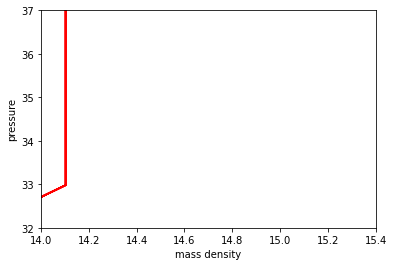

There were 0 bad samples.


In [24]:
count = 0
numbad = 0

for i in range(60):  #for i in range(len(sd_gamma0))
    
    count +=1 
    
    try: 
        gam0 = float(predictions[0][i])
        gam1 = float(predictions[1][i])
        gam2 = float(predictions[2][i])
        gam3 = float(predictions[3][i])
    
        ipred_EOS = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(gam0,gam1,gam2,gam3)
    
        ipred_h = np.linspace(0.0001,lal.SimNeutronStarEOSMaxPseudoEnthalpy(ipred_EOS),1000)

        ipred_hmin = 0.0001
        ipred_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(ipred_EOS)
    
        ipred_loghmin = np.log10(ipred_hmin)
        ipred_loghmax = np.log10(ipred_hmax)

        ipred_rho = []
        ipred_p = []

        for k in range(len(ipred_h)):
            ipred_rho.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*.001)
            ipred_p.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(ipred_h[k],ipred_EOS)*10)
            
        ipred_rho = np.array(ipred_rho)
        ipred_p = np.array(ipred_p)

        plt.plot(np.log10(ipred_rho),np.log10(ipred_p),alpha=0.25,color='red')
        
        plt.xlabel("mass density")
        plt.ylabel("pressure")
        
        print(count)
        
    except:
        print(count, " no good")
        numbad += 1
    
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.xlabel("mass density")
plt.ylabel("pressure")
plt.show() 

print("There were", numbad, "bad samples.")